In [13]:
# 初始化配置
import qlib
from qlib.constant import REG_CN
data_uri = '~/.qlib/qlib_data/cn_data/'
qlib.init(provider_uri=data_uri, region=REG_CN)

# 使用"配置"进行实例化
from qlib.utils import init_instance_by_config
qdl_config = {
    "class": "QlibDataLoader",
    "module_path": "qlib.data.dataset.loader",
    "kwargs": {
        "config": {
            "feature": (['EMA($close, 10)', 'EMA($close, 30)'], ['EMA10', 'EMA30'] ),
            "label": (['Ref($close, -1)/$close - 1',],['RET_1',]),
        },
        "freq": 'day',
    },
}
qdl = init_instance_by_config(qdl_config)
market = 'csi300' # 沪深300股票池代码，在instruments文件夹下有对应的sh000300.txt
qdl.load(instruments=market, start_time='20200101', end_time='20200110')

[909548:MainThread](2024-11-27 21:18:56,747) INFO - qlib.Initialization - [config.py:416] - default_conf: client.
[909548:MainThread](2024-11-27 21:18:56,750) INFO - qlib.Initialization - [__init__.py:74] - qlib successfully initialized based on client settings.
[909548:MainThread](2024-11-27 21:18:56,751) INFO - qlib.Initialization - [__init__.py:76] - data_path={'__DEFAULT_FREQ': PosixPath('/home/hhh/.qlib/qlib_data/cn_data')}


feature                label
                           EMA10      EMA30     RET_1
datetime   instrument                                
2020-01-02 SH600000     9.171472   9.060854  1.010425
           SH600004     6.221383   6.198955  0.992009
           SH600009    25.708969  25.645361  0.999224
           SH600010     4.653900   4.625497  1.007519
           SH600011     2.117210   2.154742  1.000000
...                          ...        ...       ...
2020-01-10 SZ300347    17.478148  17.084019  0.994388
           SZ300408     2.253388   2.172849  1.002635
           SZ300413     5.067583   4.742254  1.017136
           SZ300433     2.601543   2.478502  1.060436
           SZ300498     1.029452   1.002125  1.013001

[2100 rows x 3 columns]

In [8]:
# 实现一个自定义的特征集，MACD、RSI

from qlib.data.dataset.handler import DataHandlerLP

class MyFeatureSet(DataHandlerLP):
    def __init__(self,
                 instruments="csi300", 
                 start_time=None,
                 end_time=None,
                 freq="day",
                 infer_processors=[],
                 learn_processors=[],
                 fit_start_time=None,
                 fit_end_time=None,
                 process_type=DataHandlerLP.PTYPE_A,
                 filter_pipe=None,
                 **kwargs,
                ):
        data_loader = {
            "class": "QlibDataLoader",
            "kwargs": {
                "config": {
                    "feature": self.get_feature_config(),
                    "label": kwargs.get("label", self.get_label_config()), # label可以自定义，也可以使用初始化时候的设置
                },
                "filter_pipe": filter_pipe,
                "freq": freq,
                },
            }
        super().__init__(
            instruments=instruments,
            start_time=start_time,
            end_time=end_time,
            data_loader=data_loader,
            infer_processors=infer_processors,
            learn_processors=learn_processors,
            process_type=process_type,
        )
        
    def get_feature_config(self):
        
        MACD = '(EMA($close, 12) - EMA($close, 26))/$close - EMA((EMA($close, 12) - EMA($close, 26))/$close, 9)/$close'
        RSI = '100 - 100/(1+(Sum(Greater($close-Ref($close, 1),0), 14)/Count(($close-Ref($close, 1))>0, 14))/ (Sum(Abs(Greater(Ref($close, 1)-$close,0)), 14)/Count(($close-Ref($close, 1))<0, 14)))'
        
        return [MACD, RSI ], ['MACD', 'RSI']

    def get_label_config(self):
        return (["Ref($close, -1)/$close - 1"], ["LABEL"])

# 初始化的过程中已经完成的数据的load
my_feature = MyFeatureSet(instruments='csi300', start_time='2017-01-01', end_time='2018-12-31')

# my_feature.get_feature_config()
my_feature.fetch() # my_feature.fetch(col_set='feature') / my_feature.fetch(col_set='label')

[2082340:MainThread](2024-12-02 21:27:12,908) INFO - qlib.timer - [log.py:127] - Time cost: 1.733s | Loading data Done
[2082340:MainThread](2024-12-02 21:27:12,909) INFO - qlib.timer - [log.py:127] - Time cost: 0.000s | fit & process data Done
[2082340:MainThread](2024-12-02 21:27:12,910) INFO - qlib.timer - [log.py:127] - Time cost: 1.735s | Init data Done


MACD        RSI     LABEL
datetime   instrument                               
2017-01-03 SH600000   -0.011053  21.939018  0.001834
           SH600008   -0.004141  57.575714  0.007246
           SH600009   -0.001988  59.183758  0.005253
           SH600010   -0.010420  37.498512  0.000000
           SH600015   -0.011868  37.209003  0.005386
...                         ...        ...       ...
2018-12-28 SZ300144   -0.006135  67.208672 -0.085714
           SZ300251    0.007292  42.944771  0.022368
           SZ300296   -0.015401  43.870964 -0.016905
           SZ300408   -0.004692  49.664413 -0.043735
           SZ300433   -0.013095  14.838701 -0.018433

[146100 rows x 3 columns]

In [1]:

import qlib
from qlib.constant import REG_CN
data_uri = '~/.qlib/qlib_data/cn_data/'
qlib.init(provider_uri=data_uri, region=REG_CN)
from qlib.data.dataset.handler import DataHandlerLP

# 使用"配置"进行实例化
from qlib.utils import init_instance_by_config
from qlib.contrib.data.handler import Alpha158
from qlib.data.dataset import TSDatasetH
from qlib.contrib.model.pytorch_alstm_ts import ALSTM

# 配置数据
train_period = ("2017-01-01", "2018-12-31")
valid_period = ("2019-01-01", "2019-12-31")
test_period = ("2020-01-01", "2020-08-01")

dh = Alpha158(instruments='csi300', 
              start_time=train_period[0], 
              end_time=test_period[1],
             fit_start_time = "2018-01-01",
             fit_end_time = "2019-12-31",
              infer_processors= [
                        {"class": "RobustZScoreNorm", "kwargs": {"fields_group": "feature", "clip_outlier": "true"}},
                        {"class": "Fillna", "kwargs": {"fields_group": "feature"}},
                    ],
            learn_processors= [
                        "DropnaLabel",
                        {"class": "CSRankNorm", "kwargs": {"fields_group": "label"}},  # CSRankNorm
                    ],
             )
ds = TSDatasetH(handler=dh,
                step_len=20, # 时间步数
                segments={"train": train_period, 
                          "valid": valid_period, 
                          "test": test_period})


[2336034:MainThread](2024-12-04 21:18:55,584) INFO - qlib.Initialization - [config.py:416] - default_conf: client.
[2336034:MainThread](2024-12-04 21:18:55,797) INFO - qlib.Initialization - [__init__.py:74] - qlib successfully initialized based on client settings.
[2336034:MainThread](2024-12-04 21:18:55,798) INFO - qlib.Initialization - [__init__.py:76] - data_path={'__DEFAULT_FREQ': PosixPath('/home/hhh/.qlib/qlib_data/cn_data')}


ModuleNotFoundError. CatBoostModel are skipped. (optional: maybe installing CatBoostModel can fix it.)
ModuleNotFoundError. XGBModel is skipped(optional: maybe installing xgboost can fix it).
-------------DropnaLabel: label


/home/hhh/proj/qlib-main/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[2336034:MainThread](2024-12-04 21:19:10,502) INFO - qlib.timer - [log.py:127] - Time cost: 13.251s | Loading data Done
/home/hhh/proj/qlib-main/venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1095: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
[2336034:MainThread](2024-12-04 21:19:14,074) INFO - qlib.timer - [log.py:127] - Time cost: 3.493s | RobustZScoreNorm Done
[2336034:MainThread](2024-12-04 21:19:14,203) INFO - qlib.timer - [log.py:127] - Time cost: 0.128s | Fillna Done
[2336034:MainThread](2024-12-04 21:19:14,280) INFO - qlib.timer - [log.py:127] - Time cost: 0.050s | DropnaLabel Done
/home/hhh/proj/qlib-main/qlib/data/dataset/processor.py:37

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
#%%
from qlib.data.dataset.handler import DataHandlerLP
dl_train = ds.prepare("train", col_set=["feature", "label"], data_key=DataHandlerLP.DK_L)
dl_valid = ds.prepare("valid", col_set=["feature", "label"], data_key=DataHandlerLP.DK_L)


In [3]:
dl_train.config(fillna_type="ffill+bfill")  # process nan brought by dataloader
dl_valid.config(fillna_type="ffill+bfill")

In [4]:
import numpy as np
import torch.nn as nn
import torch
import math
seed = 32
np.random.seed(seed) 
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.manual_seed(seed)

train_loader = DataLoader(
dl_train, batch_size=5192, shuffle=True, num_workers=0, drop_last=True
)
valid_loader = DataLoader(
dl_valid, batch_size=5192, shuffle=True, num_workers=0, drop_last=True
)

Epoch 0
train 1.102622, valid 1.509614
Epoch 1
train 1.057971, valid 1.298217
Epoch 2
train 1.040887, valid 1.503150
Epoch 3
train 1.034133, valid 1.189618
Epoch 4
train 1.029072, valid 1.844866
Epoch 5
train 1.026484, valid 1.320875
Epoch 6
train 1.021960, valid 1.675927
Epoch 7
train 1.021513, valid 1.189604
Epoch 8
train 1.019238, valid 1.327516
Epoch 9
train 1.018718, valid 1.249582
Epoch 10
train 1.016556, valid 1.472861
Epoch 11
train 1.016545, valid 1.298970
Epoch 12
train 1.015905, valid 2.430757
Epoch 13
train 1.014346, valid 2.085375
Epoch 14
train 1.013438, valid 1.280744
Epoch 15
train 1.014361, valid 2.355410
Epoch 16
train 1.013261, valid 1.471952
Epoch 17
train 1.012881, valid 1.240915
Epoch 18
train 1.011643, valid 1.209588
Epoch 19
train 1.012077, valid 1.180252
Epoch 20
train 1.011301, valid 1.197152
Epoch 21
train 1.011338, valid 2.470756
Epoch 22
train 1.010974, valid 1.409614
Epoch 23
train 1.010380, valid 2.218814
Epoch 24
train 1.010385, valid 1.995189
Epoch 25
t

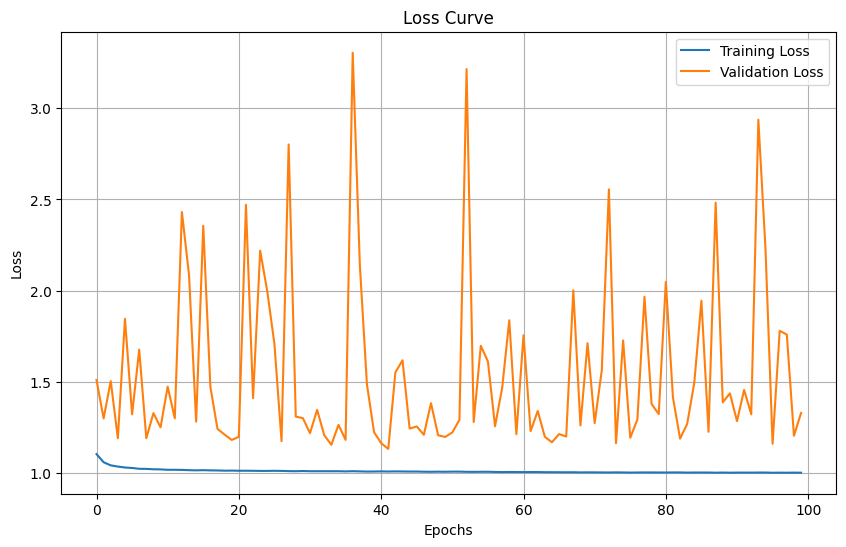

In [5]:
from transformerModule import train_transformer, test_transformer,TransformerModule
import matplotlib.pyplot as plt
n_epochs = 100
train_losses = []
val_losses = []
model = TransformerModule()
for epoch in range(n_epochs):
    print("Epoch %d" % epoch)
    # train_transformer(train_loader, epoch)
    train_loss =train_transformer(train_loader, epoch, model)
    val_loss = test_transformer(valid_loader)
    print("train %.6f, valid %.6f" % (train_loss, val_loss))
    train_losses.append(train_loss)
    val_losses.append(val_loss)


# 绘制损失曲线
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
 
# 绘制损失曲线
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
for batch_idx, inputs in enumerate(train_loader):  
    if batch_idx == 1:  
        one_batch_data = inputs
        break   


In [19]:
one_batch_data

tensor([[[ 0.1387,  0.1772,  0.1145,  ...,  0.2158,  0.4777,  2.0210],
         [ 0.8577,  0.0810,  0.7436,  ...,  0.2945, -0.1825,  1.9877],
         [ 1.3295,  0.0739,  1.1570,  ...,  0.3415,  0.7349,  2.0322],
         ...,
         [ 1.6707,  0.6314,  1.1274,  ...,  0.6846, -0.4380,  1.9925],
         [ 0.2362, -0.3038,  0.2558,  ..., -0.1987, -0.4414,  1.9705],
         [-0.4864,  0.5911, -0.3337,  ..., -0.5573, -0.4111,  1.9950]],

        [[ 0.8577,  0.0810,  0.7436,  ...,  0.2945, -0.1825,  1.9877],
         [ 1.3295,  0.0739,  1.1570,  ...,  0.3415,  0.7349,  2.0322],
         [-0.7952,  0.1659, -0.6604,  ...,  0.6540,  0.9253,  2.0003],
         ...,
         [ 0.2362, -0.3038,  0.2558,  ..., -0.1987, -0.4414,  1.9705],
         [-0.4864,  0.5911, -0.3337,  ..., -0.5573, -0.4111,  1.9950],
         [-1.7438,  1.5083, -0.8695,  ...,  0.1983, -0.0648,  1.9972]],

        [[ 1.3295,  0.0739,  1.1570,  ...,  0.3415,  0.7349,  2.0322],
         [-0.7952,  0.1659, -0.6604,  ...,  0

In [9]:
# 一个batch的数据
one_batch_data.shape

torch.Size([8192, 20, 159])

In [7]:

# feature: (8192,20,158)
feature = one_batch_data[:, :, 0:-1]
# 8192
label = one_batch_data[:, -1, -1]
print(feature.shape)
print(label)


torch.Size([8192, 20, 158])
tensor([0.9950, 0.9972, 0.9717,  ..., 0.9979, 0.9978, 0.9978])


In [21]:
import numpy as np
import torch.nn as nn
import torch
import torch.optim as optim
import math
seed = 32
np.random.seed(seed) 
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.manual_seed(seed)
from transformerModule import PositionalEncoding, MultiHeadAttention,TransformerModule
# linear = nn.Linear()

# input = torch.randn(20,5,158)
# mul_att1 = MultiHeadAttention(2,512,0)
# mul_att_out1 = mul_att1.forward(input)
# print(mul_att_out1)
# mul_att2 = PositionalEncoding(512, 100)
# mul_att_out2 = mul_att2.forward(input.float())
# 模型输出测试
model = TransformerModule(158, 512, 0.1, 6)
pred = model.forward(feature.float()).squeeze(-1)
train_optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-3)
mask = ~torch.isnan(label)
loss = torch.mean((pred[mask]-label[mask])**2)
train_optimizer.zero_grad()
loss.backward()
train_optimizer.step()
print(pred.shape)
print(pred)


Total number of parameters: 1296543


NameError: name 'feature' is not defined

In [12]:
torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

device(type='cuda', index=0)

In [19]:
test = torch.rand(3,4,5)

In [20]:
test

tensor([[[0.7605, 0.8524, 0.6648, 0.9480, 0.4735],
         [0.8731, 0.3785, 0.3258, 0.2027, 0.7167],
         [0.8117, 0.1121, 0.6466, 0.9719, 0.9213],
         [0.3831, 0.3930, 0.5797, 0.6329, 0.2640]],

        [[0.9705, 0.4962, 0.7696, 0.2525, 0.0741],
         [0.3559, 0.4318, 0.9146, 0.9795, 0.4408],
         [0.9902, 0.5128, 0.5951, 0.8934, 0.2516],
         [0.4185, 0.4892, 0.6723, 0.3938, 0.6720]],

        [[0.8764, 0.2443, 0.3268, 0.9680, 0.2575],
         [0.3969, 0.0577, 0.7201, 0.4786, 0.4490],
         [0.8341, 0.8497, 0.9446, 0.2704, 0.6773],
         [0.5130, 0.7120, 0.9063, 0.8501, 0.9215]]])

In [21]:
test[:,-1,:]

tensor([[0.3831, 0.3930, 0.5797, 0.6329, 0.2640],
        [0.4185, 0.4892, 0.6723, 0.3938, 0.6720],
        [0.5130, 0.7120, 0.9063, 0.8501, 0.9215]])

In [23]:
test[:,-1,:].shape

torch.Size([3, 5])